## Propósito

A aviação proporcionou ao mundo um avanço tecnologico que jamais poderia ocorrer sem a mesma. Talvez Einstein não conseguiria vir ao Brasil pra comprovar parte de sua teoria. Mas infelizmente nem tudo são flores, a aviação é inprescindivel para o meio militar, tanto para transporte de suprimentos ou tropas quanto para o ataque/defesa. 

Logo, quem domina o espaço aéreo domina as posições em solo, então as defesas anti-aéreas tem seu papel fundamental no campo de batalha. Porém, há relatos de aviões civis sendo abatidos pelas mesmas.

## Objetivo

O objetivo desse artigo é mostrar o possivel uso de uma Inteligencia Artificial, com o uso de imagens, para diferenciar um avião caça, civil ou de cargas

## Passo 1: Download de imagens de padrões e mercado lateral (Criação do banco de dados)

#### Aviões: Caça, civil e de carga.

In [1]:
from duckduckgo_search import ddg_images
from fastcore.all import *

#função para buscar imagens
def search_images(term, max_images=50):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Buscar primeiramente por topo duplo

In [2]:
urls = search_images('fighter jet', max_images=1)
urls[0]

Searching for 'fighter jet'


'http://www.hdwallpaperslife.com/wp-content/uploads/2018/06/military_fighter_jet_4k.jpg'

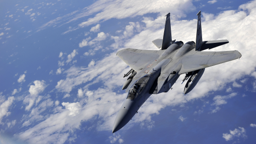

In [3]:
from fastdownload import download_url
dest = 'fighter.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Agora vamos fazer o mesmo para a aeronave civil e para a aviação de Carga

Searching for 'civil airplane'


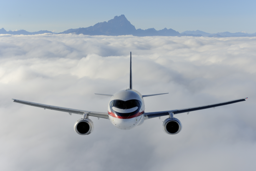

In [4]:
download_url(search_images('civil airplane', max_images=1)[0], 'civil.jpg', show_progress=False)
Image.open('civil.jpg').to_thumb(256,256)

Searching for 'cargo airplane'


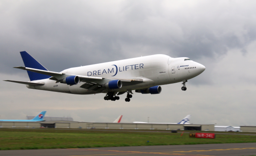

In [5]:
download_url(search_images('cargo airplane', max_images=1)[0], 'cargo.jpg', show_progress=False)
Image.open('cargo.jpg').to_thumb(256,256)

Os resultados pareceram promissores então vamos pegar algumas fotos para treino

In [6]:
searches = 'civil airplane','fighter jet','cargo airplane'
path = Path('aircrafts')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o}'))
    sleep(10)  # Pause between searches to avoid over-loading server
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'civil airplane'
Searching for 'fighter jet'
Searching for 'cargo airplane'


## Passo 2: Treinamento do Modelo

Vamos retirar as imagens que não foram baixadas corretamente do nosso banco de dados

In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
print(f'{len(failed)} imagens falharam ao baixar')

3 imagens falharam ao baixar


Para treinar nosso modelo é preciso de uma forma de carregar nosso banco de dados de uma forma que possamos dividir entre parte de treino e parte para validação. Ultilizaremos a biblioteca do `Fastai` para fazer essa separação

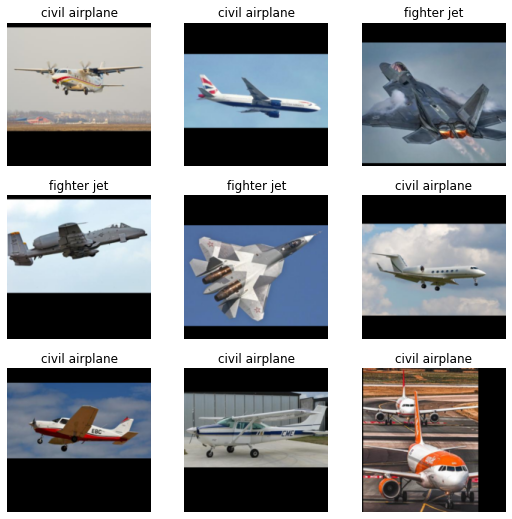

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),             # tipo de input e output
    get_items=get_image_files,                      # qual é o tipo de dado
    splitter=RandomSplitter(valid_pct=0.2, seed=42),# divisão dos dados entre teste e validação
    get_y=parent_label,                             # como saber o resultado real
    item_tfms=[Resize(192, ResizeMethod.Pad, pad_mode='zeros')]    # diminuir o tamanho da imagem para menor utilização de maquina
).dataloaders(path, bs=70)

dls.show_batch(max_n=9)

Agora vamos colocar a Inteligencia Artificial para aprender:

In [12]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

c:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.870341,2.002018,0.670588,00:40


epoch,train_loss,valid_loss,error_rate,time
0,1.125203,0.588567,0.341176,00:39
1,0.863653,0.261618,0.070588,00:35
2,0.670299,0.141601,0.023529,00:34
3,0.550326,0.115206,0.023529,00:34


vamos ver os principais erros atraves da matrix de confusão

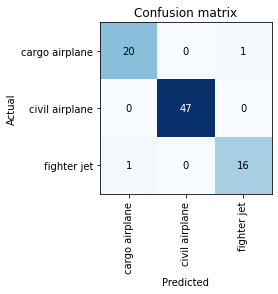

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

1 teste: Como podemos ver, nossa IA está confundindo muito aviões cargueiros com civil, isso é devido grande parte dos aviões de carga são do mesmo modelo dos civis
        
        -foi aumentado o numero de fotos no Database

        
2 Teste: principal confusão foi com os caças e aviões de carga, creio ser devido a pintura de ambos ser do mesmo estilo

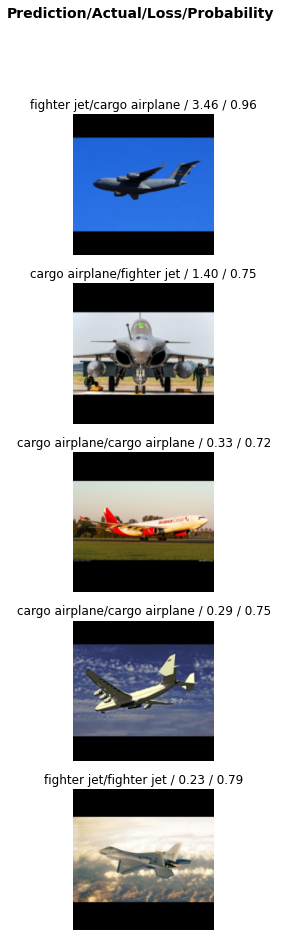

In [16]:
interp.plot_top_losses(5, nrows=5)

Logo não teríamos como refinar os dados (com seleção manual), então a melhor forma é treinando mais e buscando novas informações

Isso é um: civil airplane.
Probabilidade de ser: 98.2190%


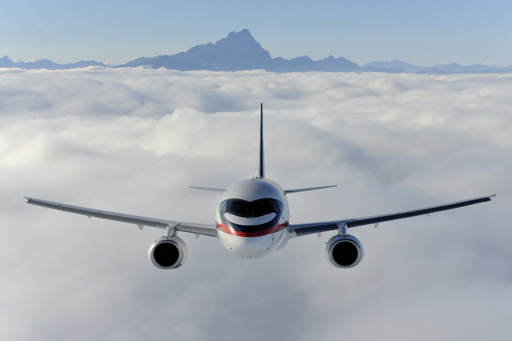

In [22]:
is_td,_,probs = learn.predict(PILImage.create('civil.jpg'))
print(f"Isso é um: {is_td}.")
print(f"Probabilidade de ser: {probs[1]*100:.4f}%")
Image.open('civil.jpg').to_thumb(512,512)

### Exportar:

In [23]:
learn.export('plane.pkl')

## Conclusões

#### Link do HuggingSpace

https://huggingface.co/spaces/theholsback/aviation

Vemos que como há muitas semelhanças visuais nos aviões, a melhor forma seria adicionando outros métodos de IA com outras fontes de informações além de visuais, por sem algo extremamente crítico essas análises. Porém, como os aviões de carga t